In [313]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [70]:
import requests
import json

In [7]:
def get(query, timeout=5, max_retries=5, backoff_factor=0.3):
    """ Выполнить GET-запрос

    :param query: запрос с адресом
    :param timeout: максимальное время ожидания ответа от сервера
    :param max_retries: максимальное число повторных запросов
    :param backoff_factor: коэффициент экспоненциального нарастания задержки
    """
    import time
    import random
    delay = 0
    for i in range(max_retries):
        try:
            response = requests.get(query)
            return response.json()
        except:
            pass
        time.sleep(delay)
        delay = min(delay * backoff_factor, timeout)
        delay += random.random()
    return response

In [21]:
def get_id_page_counts(job_name):
    query = "https://api.hh.ru/vacancies?text=" + job_name
    result = get(query)
    return (result['found'], result['pages'])

In [30]:
test_page_counts = get_id_page_counts('Data scientist')

In [25]:
def get_vacancy_ids(job_name):
    query_data = {
        "search_field": job_name,
        "page": 0
    }
    id_count, page_count = get_id_page_counts(job_name)
    id_list = []
    while query_data['page']<page_count:
        query = "https://api.hh.ru/vacancies?text={search_field}&page={page}".format(**query_data)
        result = get(query)
        query_data["page"] += 1
        for i in range(len(result['items'])):
            id_list.append(result['items'][i]['id'])
    return id_list

In [27]:
test_id_list = get_vacancy_ids('Data scientist')

In [32]:
print(len(test_id_list), test_page_counts)

441 (441, 23)


In [158]:
def parse_append(raw_data, json_data):
    if not json_data:
        json_data={
                'id': [],
                'name': [],
                'schedule': [],
                'employment':[],
                'experience':[],
                'salary_min': [],
                'salary_max': [],
                'currency': []
    }
    json_data['id'].append(raw_data['id'])
    json_data['name'].append(raw_data['name'])
    json_data['schedule'].append(raw_data['schedule']['id'])
    json_data['employment'].append(raw_data['employment']['id'])
    json_data['experience'].append(raw_data['experience']['id'])
    if raw_data['salary']:
        if raw_data['salary']['from'] == None: 
            json_data['salary_min'].append(raw_data['salary']['to'])
        else:
            json_data['salary_min'].append(raw_data['salary']['from'])
        if raw_data['salary']['to'] == None: 
            json_data['salary_max'].append(raw_data['salary']['from'])
        else:
            json_data['salary_max'].append(raw_data['salary']['to'])
        json_data['currency'].append(raw_data['salary']['currency'])
    else:
        json_data['salary_min'].append(None)
        json_data['salary_max'].append(None)
        json_data['currency'].append(None)   
    return json_data

In [159]:
def ids_to_data(id_list):
    job_json = {}
    for i in range(len(id_list)):
        query = "https://api.hh.ru/vacancies/" + id_list[i]
        job_json = parse_append(get(query), job_json)
    return job_json        

In [160]:
def get_job_data(job_name, count=None):
    id_list = get_vacancy_ids(job_name)
    if count:
        return ids_to_data(id_list[:count])
    return ids_to_data(id_list)

In [161]:
job_df=pd.DataFrame(get_job_data('Data scientist'))
job_df.head()

,id,name,schedule,employment,experience,skill_list,salary_min,salary_max,currency
0,33811532,Data Scientist (NLP),fullDay,full,between1And3,[],250000.0,250000.0,RUR
1,32434748,Data Scientist,fullDay,full,between3And6,[],NaN,NaN,None
2,30250856,Главный аналитик-математик (Data Analyst / Dat...,fullDay,full,between3And6,"[{'name': 'Data Mining'}, {'name': 'Python'}, ...",180000.0,230000.0,RUR
3,33418971,Data scientist,fullDay,full,between1And3,[],NaN,NaN,None
4,34161082,Data Scientist,flexible,full,between3And6,[],NaN,NaN,None


In [137]:
job_df.shape

(450, 5)

In [162]:
job_df[100:]

,id,name,schedule,employment,experience,skill_list,salary_min,salary_max,currency
100,34230718,Backend Developer/Data Scientist в Команду Per...,fullDay,full,noExperience,[],NaN,NaN,None
101,34179232,Data Scientist,fullDay,full,between1And3,"[{'name': 'Python'}, {'name': 'Data Mining'}, ...",NaN,NaN,None
102,34189074,Data Scientist,flexible,full,between3And6,"[{'name': 'SQL'}, {'name': 'Python'}, {'name':...",NaN,NaN,None
103,33838551,Senior Data Scientist,fullDay,full,between3And6,"[{'name': 'Spark'}, {'name': 'Python'}, {'name...",NaN,NaN,None
104,34196273,Data Scientist,fullDay,full,noExperience,"[{'name': 'Python'}, {'name': 'Data Mining'}, ...",NaN,NaN,None
105,31581584,Data Scientist в проект CRM,fullDay,full,between3And6,"[{'name': 'Python'}, {'name': 'Churn Predictio...",NaN,NaN,None
106,33478456,Data Scientist,fullDay,full,between3And6,[],NaN,NaN,None
107,34183768,Data Scientist,flexible,full,between1And3,"[{'name': 'Data Analysis'}, {'name': 'SQL'}, {...",NaN,NaN,None
108,34182482,Математик/ Junior Data Scientist,fullDay,full,between1And3,[],NaN,NaN,None
109,34239593,Data Scientist /Руководитель направления иссле...,fullDay,full,between1And3,[],NaN,NaN,None


In [262]:
def normalize_currency(job_entry):
    if job_entry['currency'] == 'USD':
        job_entry['currency'] = 'RUR'
        job_entry['salary'] *= 65
    if job_entry['currency'] == 'EUR':
        job_entry['currency'] = 'RUR'
        job_entry['salary'] *= 75
    return job_entry

In [264]:
def normalize_salary(job_df):
    job_df.insert(loc=4, column='salary', value=((job_df['salary_min']+job_df['salary_max'])/2))
    job_df.apply(normalize_currency, 1)
    return job_df.drop(columns=['salary_min', 'salary_max'])

In [184]:
job_df_list={
    'data scientist': {},
    'бизнес аналитик': {},
    'web разработчик': {},
    'python программист': {}
}
for i in job_df_list.keys():
    job_df_list[i] = pd.DataFrame(get_job_data(i))

In [192]:
job_df_list['data scientist'].head(400)

,id,name,schedule,employment,experience,skill_list,salary_min,salary_max,currency
0,32377243,Аналитик данных / Data Scientist,fullDay,full,between1And3,[],120000.0,180000.0,RUR
1,33811532,Data Scientist (NLP),fullDay,full,between1And3,[],250000.0,250000.0,RUR
2,33840192,Python Data Scientist,fullDay,full,between1And3,[],150000.0,150000.0,RUR
3,32434748,Data Scientist,fullDay,full,between3And6,[],NaN,NaN,None
4,30250856,Главный аналитик-математик (Data Analyst / Dat...,fullDay,full,between3And6,"[{'name': 'Data Mining'}, {'name': 'Python'}, ...",180000.0,230000.0,RUR
5,33418971,Data scientist,fullDay,full,between1And3,[],NaN,NaN,None
6,34161082,Data Scientist,flexible,full,between3And6,[],NaN,NaN,None
7,33884132,Data scientist,fullDay,full,between1And3,[],NaN,NaN,None
8,30758063,Data Scientist,fullDay,full,between1And3,"[{'name': 'Статистическое моделирование'}, {'n...",NaN,NaN,None
9,34249318,Стажер Data Scientist,flexible,probation,noExperience,"[{'name': 'Python'}, {'name': 'MATLAB'}, {'nam...",NaN,NaN,None


In [200]:
job_df_list['бизнес аналитик'].tail(500)

,id,name,schedule,employment,experience,skill_list,salary_min,salary_max,currency
1500,33012087,Операционный директор сети ресторанов,fullDay,full,between3And6,"[{'name': 'Ресторанный менеджмент'}, {'name': ...",NaN,NaN,None
1501,33624032,"Аналитик (кредитный конвейер, микросервисная а...",fullDay,full,between1And3,[],NaN,NaN,None
1502,34254663,Руководитель продукта (Product owner),fullDay,full,between3And6,[],NaN,NaN,None
1503,33711946,Системный аналитик,fullDay,full,between1And3,"[{'name': 'ГОСТ'}, {'name': 'SQL'}, {'name': '...",NaN,NaN,None
1504,32871780,Middle+/Senior Business Analyst,fullDay,full,between3And6,"[{'name': 'IT Business Analyst'}, {'name': 'E-...",NaN,NaN,None
1505,33906610,Frontend Developer,fullDay,full,between3And6,"[{'name': 'JavaScript'}, {'name': 'AngularJS'}...",NaN,NaN,None
1506,33047052,Системный аналитик (POS системы),fullDay,full,between1And3,"[{'name': 'MS SQL'}, {'name': 'Разработка техн...",NaN,NaN,None
1507,33712162,Системный аналитик,fullDay,full,between1And3,"[{'name': 'ГОСТ'}, {'name': 'SQL'}, {'name': '...",NaN,NaN,None
1508,33399186,Специалист по контекстной рекламе,fullDay,full,between1And3,"[{'name': 'Контекстная реклама'}, {'name': 'Ав...",NaN,NaN,None
1509,34005445,Веб-программист (full-stack),fullDay,full,between3And6,"[{'name': 'JavaScript'}, {'name': 'jQuery'}, {...",NaN,NaN,None


In [355]:
job_df_full = job_df_list['бизнес аналитик'].head(400)
job_df_full.insert(loc=2, column='job_type', value = 'бизнес аналитик')
job_df_full = job_df_full.append(job_df_list['python программист'].head(400))
job_df_full['job_type'] = job_df_full['job_type'].fillna('python программист')
job_df_full = job_df_full.append(job_df_list['web разработчик'].head(400))
job_df_full['job_type'] = job_df_full['job_type'].fillna('web разработчик')
job_df_full = job_df_full.append(job_df_list['data scientist'].head(400))
job_df_full['job_type'] = job_df_full['job_type'].fillna('data scientist')

In [309]:
job_df_full

,currency,employment,experience,id,job_type,name,salary_max,salary_min,schedule,skill_list
0,RUR,full,between3And6,34265101,бизнес аналитик,Бизнес-аналитик,150000.0,150000.0,fullDay,"[{'name': 'UML'}, {'name': 'BPMN'}, {'name': '..."
1,RUR,full,between1And3,32928574,бизнес аналитик,Старший бизнес-аналитик,230000.0,190000.0,fullDay,[]
2,RUR,full,between3And6,33812177,бизнес аналитик,Бизнес-Аналитик,140000.0,90000.0,fullDay,[{'name': 'настойчивость в достижении результа...
3,RUR,full,between1And3,33765112,бизнес аналитик,Бизнес аналитик,180000.0,180000.0,fullDay,"[{'name': 'BPMN'}, {'name': 'MS Visio'}, {'nam..."
4,RUR,full,between3And6,34098595,бизнес аналитик,Бизнес-аналитик,150000.0,150000.0,fullDay,[]
5,RUR,full,between3And6,33829692,бизнес аналитик,Бизнес аналитик,150000.0,150000.0,flexible,"[{'name': 'Ведение переговоров'}, {'name': 'Пр..."
6,None,full,between1And3,34264974,бизнес аналитик,Бизнес-аналитик,NaN,NaN,fullDay,"[{'name': 'UML'}, {'name': 'Use Case Analysis'..."
7,RUR,full,between1And3,34161593,бизнес аналитик,Бизнес-аналитик / Системный аналитик,180000.0,110000.0,fullDay,"[{'name': 'Системный анализ'}, {'name': 'UML'}..."
8,RUR,full,between1And3,33133358,бизнес аналитик,Бизнес-аналитик,100000.0,80000.0,fullDay,[]
9,RUR,full,between3And6,33997481,бизнес аналитик,Бизнес-аналитик в Департамент информационных т...,165000.0,140000.0,fullDay,[]


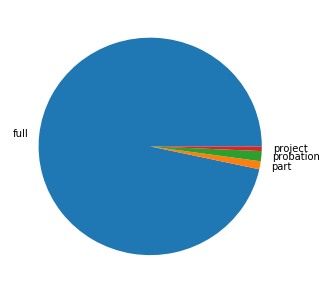

In [247]:
job_df_class = job_df_full.groupby('employment').size()
job_df_class.plot(kind='pie', figsize=(5, 5), label="")

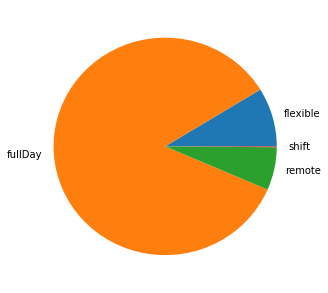

In [248]:
job_df_class = job_df_full.groupby('schedule').size()
job_df_class.plot(kind='pie', figsize=(5, 5), label="")

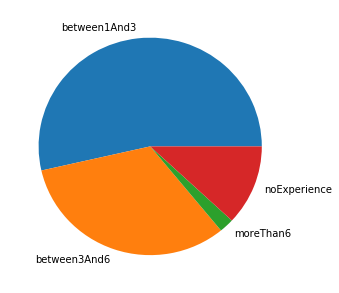

In [311]:
job_df_class = job_df_full.groupby('experience').size()
job_df_class.plot(kind='pie', figsize=(5, 5), label="")

In [341]:
job_df_full['job_type'] = job_df_full['job_type'].astype('category').cat.codes

In [366]:
x_var = 'job_type'
groupby_var = 'experience'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]

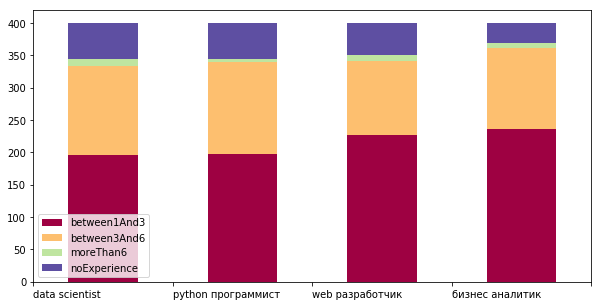

In [380]:
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins, np.unique(job_df_full[x_var]).tolist(), rotation=0, horizontalalignment='left')
plt.show()

In [289]:
job_df_full = job_df_full.drop(columns='salary')

In [382]:
normalize_salary(job_df_full)

,currency,employment,experience,id,salary,job_type,name,schedule,skill_list
0,RUR,full,between3And6,34265101,150000.0,бизнес аналитик,Бизнес-аналитик,fullDay,"[{'name': 'UML'}, {'name': 'BPMN'}, {'name': '..."
1,RUR,full,between1And3,32928574,210000.0,бизнес аналитик,Старший бизнес-аналитик,fullDay,[]
2,RUR,full,between3And6,33812177,115000.0,бизнес аналитик,Бизнес-Аналитик,fullDay,[{'name': 'настойчивость в достижении результа...
3,RUR,full,between1And3,33765112,180000.0,бизнес аналитик,Бизнес аналитик,fullDay,"[{'name': 'BPMN'}, {'name': 'MS Visio'}, {'nam..."
4,RUR,full,between3And6,34098595,150000.0,бизнес аналитик,Бизнес-аналитик,fullDay,[]
5,RUR,full,between3And6,33829692,150000.0,бизнес аналитик,Бизнес аналитик,flexible,"[{'name': 'Ведение переговоров'}, {'name': 'Пр..."
6,None,full,between1And3,34264974,NaN,бизнес аналитик,Бизнес-аналитик,fullDay,"[{'name': 'UML'}, {'name': 'Use Case Analysis'..."
7,RUR,full,between1And3,34161593,145000.0,бизнес аналитик,Бизнес-аналитик / Системный аналитик,fullDay,"[{'name': 'Системный анализ'}, {'name': 'UML'}..."
8,RUR,full,between1And3,33133358,90000.0,бизнес аналитик,Бизнес-аналитик,fullDay,[]
9,RUR,full,between3And6,33997481,152500.0,бизнес аналитик,Бизнес-аналитик в Департамент информационных т...,fullDay,[]


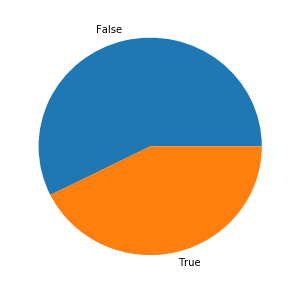

In [383]:
job_df_class = job_df_full.groupby(job_df_full['salary']>0).size()
job_df_class.plot(kind='pie', figsize=(5, 5), label="")
plt.show()